In [1]:
import matlab.engine
import numpy as np
import scipy.optimize

# Trial and pd parameters

In [2]:
# trial and adherence information
drug = "ATV/r"

days = np.double(40) #days to run trial for
increment = 0.01 # days between each timepoint returned
prob_adh = 0.5 if drug != 'TEST' else 0. # probability of taking each pill (independent)
adh_pat = 0 # 0 = random prob for each dose, 1 = random prob each day after missed dose
adh_shuff = np.double(0.) # standard deviation in the time of taking a pill vs scheduled (days)
trial_type = 1 # 1 = suppression trial, 0=maintenance trial
burnin = 7*5 # days before interval sampling begins in maintenance trials
sampling_int = 28 # days between each sampling time in maintenance trials
threshold = 200 # threshold viral load above which failure is declared
mut_frac = 0.2 # threshold fraction of population of mutant above which declared failure via resistance

## Use existing matlab scripts to calculate concentration(t)

In [3]:
eng = matlab.engine.start_matlab()
eng.cd(r'~/develop/withinhostHIV/MatlabCode/', nargout=0)
eng.eval("addpath('Parameters','Utilities')", nargout=0)

In [4]:
eng.workspace["drug"] = drug
trial, pd = eng.trial_setup(eng.eval("drug"), days, increment, prob_adh, adh_pat, adh_shuff, trial_type, burnin, sampling_int, threshold, mut_frac, nargout=2)
eng.workspace["trial"] = trial
eng.workspace["pd"] = pd

In [5]:
dose_t, _ = eng.adh_trajectory(eng.eval("pd.num_doses"), trial, nargout=2)

In [6]:
c_vec,inhib_vec = eng.drug_trajectory(pd, trial, dose_t, nargout=2)

## Use existing matlab scripts to calculate mutation matrix Q

In [7]:
smin=0.05; #highest mutant fitness
smax=0.9; #lowest mutant fitness
smiss=0.05; #fitness of strains with missing cost
rfmiss=1; #fold change in resistance for strains with it missing
mfmiss=0; #fractional change in slope for strains with it missing
back_mutation_on = drug != 'TEST' #include(1) or exclude(0) back mutation
direct_multi_hit = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from WT
direct_multi_multi = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from one res strain to another

In [8]:
mparams,Q = eng.getMutInfo(drug,smin,smax,smiss,rfmiss,mfmiss,back_mutation_on,direct_multi_hit,direct_multi_multi,nargout=2);
eng.workspace["Q"] = Q
Q = eng.eval("Q{:,:};") # get a matrix instead of a matlab table

## Viral dynamics parameters

In [9]:
R00 = 10.0 # average number of new virions produced by infection with a single virion === average number of new infected cells produced by 1 infected cell
fbp = 0.55 # fraction of blood that is plasma
Vpl = 3*10e3 # volume of plasma in mL
ftcell_pl = 0.02 # fraction of T cells that are circulating in blood (vs in lymph system)
hl_lr = 44*30.5 # half life of decay of latent reservoir, days
A = 100 # total reactivation of latent cells per day
flr = 1e-6# fraction of CD4 T cells that are latently infected at equilibrium

scale_cd4_body = (Vpl*10**3)/(fbp*ftcell_pl) # factor to go from T cell per ul blood to whole body

fa = 0.01 # fraction of infected CD4 cells that support productive vs abortive infection
dx = 0.05 # death rate of uninfected cells (per day) and by assumption dx == d, rate of death without viral cytolytic effects
L = scale_cd4_body*1000*dx # uninfected cells produced per day (/ul)
a = A/(flr*L/dx) # rate of exit of latent cells (per day)
dz = np.log(2)/(hl_lr)-a # death rate of latently infected cells (per day)

dy = 1 # TOTAL death rate of infected cells (per day) (=death due to burst (k) + death without viral cytolytic effects)
k = dy-dx # rate of death+emission of a burst of virions (per day)
N = 2.38e5
assert(N > R00)

# probability of a single virion establishing infection, solved implicitly
p_est_solution = scipy.optimize.least_squares(lambda p_est: R00*(1-(1-p_est)**N) - N*p_est, 0.1)
assert(p_est_solution.success)
p_est = p_est_solution.x

dv = 25 # TOTAL death rate of virions (per day)
beta = R00 * dy * dv * dx / (k * N * fa * L) # infectivity rate (per day*infectious-target cell pair)
c = dv-beta*L/dx # clearance rate of virions (per day);
assert(c > 0)
g = flr*dy/dx*(a+dz)/(fa*(1-1/R00)) # fraction of new infections that become latent

In [10]:
# Access matlab parameters
eng.workspace["mparams"] = mparams
IC50 = eng.eval('pd.IC50')
m = eng.eval('pd.m')
cost = eng.eval('mparams.cost')
rf = eng.eval('mparams.rf')
mf = eng.eval('mparams.mf')
msb = np.asarray(eng.eval("mparams.msb"))
t_vec = eng.eval('(0:trial.increment:trial.days);')


## Check beta(t) (from matlab) against beta(t) (from python)

In [11]:
_beta_t, _beta_u_t = eng.calculate_beta_of_t(t_vec, beta, c_vec, IC50, m, cost, rf, mf, eng.eval('height(mparams)'), nargout=2)

In [12]:
from numba import jit

@jit(nopython=True)
def calculate_beta_t(beta_0, concentration, IC50, m, cost, rf, mf):
    # B/[cost * (1 + concentration)/(IC50*rf)^(m*(1+mf))]
    B = beta_0
    denominator = cost * (1 + (concentration/(IC50*rf))**(m*(1+mf)))
    return B/denominator


# make sure we didn't mess up our function definition
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T), np.asarray(_beta_u_t)))
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1), np.asarray(_beta_t)))

beta_u_t = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T)
beta_t   = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1)

beta_t = np.concatenate([beta_t, beta_u_t], axis=1)
t_vec = np.asarray(t_vec).squeeze()
dose_t = np.asarray(dose_t).T.squeeze()

In [13]:
beta_t

array([[5.72353685e-29, 1.80640339e-19, 3.44853164e-20, 1.34826435e-18],
       [6.42910440e-29, 1.87704557e-19, 3.58339359e-20, 1.40343211e-18],
       [7.22165060e-29, 1.95045026e-19, 3.72352957e-20, 1.46085702e-18],
       ...,
       [5.04088889e-19, 3.34240624e-16, 6.53918872e-17, 3.03318773e-15],
       [5.66229450e-19, 3.46864531e-16, 6.79253626e-17, 3.13599429e-15],
       [6.36030146e-19, 3.59947719e-16, 7.05560340e-17, 3.24154368e-15]])

In [14]:
sampled_concentration = np.asarray(c_vec)

increment = eng.eval('trial.increment')

# closed around parameters
# pulls the nearest beta pre-calculated to the left of the current time
@jit(nopython=True)
def discrete_beta_of_t(t):
    # last time where beta was precalculated *before* t
    # specifically want *before* t so that we don't look ahead while integrating past a discontinuity
    t_discrete = int(np.floor(t/increment))
    return beta_t[t_discrete]

Q = np.asarray(Q)
@jit(nopython=True)
def force_of_infection(t):
    beta = discrete_beta_of_t(t)
    # calculate force of infection and flatten in row major order, which will make the matrix
    # read correctly in our 1-dimensional vector of rates

    # **NOTE* we moved FA to the stoichiometry matrix, otherwise it would be a factor below!
    return (np.expand_dims(beta,1) * Q).flatten()

TODO: triple check to make sure this is the right orientation of beta_i relative to Q

In [15]:
Q

array([[1.00000000e+00, 9.31401597e-07, 1.15302567e-05, 1.15302033e-05],
       [6.38285140e-06, 1.00000000e+00, 7.35959154e-11, 7.35955744e-11],
       [4.29936191e-05, 4.00443255e-11, 1.00000000e+00, 4.95725170e-10],
       [2.62179380e-05, 2.44194294e-11, 3.02299557e-10, 1.00000000e+00]])

In [16]:
print(Q[0,1], Q[1,0], ". Q[0,1] > Q[1,0]:", Q[0,1] > Q[1,0])

9.314015974243431e-07 6.382851399191302e-06 . Q[0,1] > Q[1,0]: False


In [17]:
row_i, col_i = np.triu_indices_from(Q)
for i,j in zip(list(row_i), list(col_i)):
    print(Q[i,j] > Q[j,i])

False
False
False
False
False
True
True
False
True
False


In [18]:
np.expand_dims(beta_t[0],1)

array([[5.72353685e-29],
       [1.80640339e-19],
       [3.44853164e-20],
       [1.34826435e-18]])

# Define model

In [19]:
import reactionmodel.model as reactionmodel
from importlib import reload
reload(reactionmodel)
num_strains = beta_t.shape[1]
num_strains

4

In [20]:
ys = [reactionmodel.Species(f'infected cells strain {i}', f'y{i}') for i in range(num_strains)]
zs = [reactionmodel.Species(f'latent cells strain {i}', f'z{i}') for i in range(num_strains)]
vs = [reactionmodel.Species(f'viruses strain {i}', f'v{i}') for i in range(num_strains)]
x = reactionmodel.Species("target cells", "x")
all_species = [x] + ys + vs + zs

In [21]:
target_cell_birth = reactionmodel.Reaction("target cell birth", [], [x], k=L)
target_cell_death = reactionmodel.Reaction("target cell death", [x], [], k=dx)
infected_death = [reactionmodel.Reaction(f"death of infected cell strain {i}", [ys[i]], [], k=(dy-k)) for i in range(num_strains)]
infected_cell_burst = [reactionmodel.Reaction(f"burst of infected cell strain {i}", [ys[i]], [(vs[i], N)], k=k) for i in range(num_strains)]
into_latency = [reactionmodel.Reaction(f"strain {i} --> latency", [ys[i]], [zs[i]], k=g) for i in range(num_strains)]
out_of_latency = [reactionmodel.Reaction(f"latent --> strain {i}", [zs[i]], [ys[i]], k=a) for i in range(num_strains)]
death_of_latent = [reactionmodel.Reaction(f"latent {i} death", [zs[i]], [], k=dz) for i in range(num_strains)]
viral_clearance = [reactionmodel.Reaction(f"clearance of strain {i} virion", [vs[i]], [], k=c) for i in range(num_strains)]

infections = []
for i in range(num_strains):
    for j in range(num_strains):
        infections.append(reactionmodel.Reaction(f"infection of x by {i}->{j}", [x, vs[i]], [(ys[j], fa)]))
infection_family = reactionmodel.ReactionRateFamily(infections, k=force_of_infection)

all_reactions = [target_cell_birth, target_cell_death] + infected_death + infected_cell_burst + into_latency + out_of_latency + death_of_latent + viral_clearance + [infection_family]


In [22]:
from types import FunctionType as function
from numba.core.registry import CPUDispatcher
isinstance(all_reactions[-1].k, CPUDispatcher)

True

In [23]:
model = reactionmodel.Model(all_species, all_reactions)

In [24]:
for reaction in model.all_reactions:
    print(reaction)

Reaction(name=target cell birth, description=, reactants=(), products=(Species(name='target cells', description='x'),), rate_involvement=(), k=136363636363.63635)
Reaction(name=target cell death, description=, reactants=(Species(name='target cells', description='x'),), products=(), rate_involvement=(Species(name='target cells', description='x'),), k=0.05)
Reaction(name=death of infected cell strain 0, description=, reactants=(Species(name='infected cells strain 0', description='y0'),), products=(), rate_involvement=(Species(name='infected cells strain 0', description='y0'),), k=0.050000000000000044)
Reaction(name=death of infected cell strain 1, description=, reactants=(Species(name='infected cells strain 1', description='y1'),), products=(), rate_involvement=(Species(name='infected cells strain 1', description='y1'),), k=0.050000000000000044)
Reaction(name=death of infected cell strain 2, description=, reactants=(Species(name='infected cells strain 2', description='y2'),), products=()

# Run forward simulation

In [25]:
import hybrid

In [26]:
ys

[Species(name='infected cells strain 0', description='y0'),
 Species(name='infected cells strain 1', description='y1'),
 Species(name='infected cells strain 2', description='y2'),
 Species(name='infected cells strain 3', description='y3')]

In [58]:
extra_discontinuities = list(np.linspace(0.0,40.0,400))
extra_discontinuities = []

y0 = np.zeros(len(all_species))
y0[model.species_index[x]] = L/dx/R00

expanded_msb = np.squeeze(np.vstack([np.array([1]), msb]))
y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] = fa*(1-1/R00)*L/dy * expanded_msb
y0[model.species_index[zs[0]] : model.species_index[zs[-1]] + 1] = y0[model.species_index[ys[0]] : model.species_index[ys[-1]] + 1] * g/(a+dz)

In [59]:
y0[model.species_index[zs[0]] : model.species_index[zs[-1]] + 1]

array([2.72727273e+06, 3.38679202e+00, 3.83408502e+01, 5.72193503e+01])

In [60]:
y0[model.species_index[zs[3]]] / (L/dx) * 1e6

2.098042843818336e-05

In [61]:
%load_ext jupyterflame

The jupyterflame extension is already loaded. To reload it, use:
  %reload_ext jupyterflame


In [62]:
# the adherence pattern and hence the R0s is being determined in matlab before any of this code runs,
# so don't be scared if trajectories look almost identical with different seeds in python

rng = np.random.default_rng()
result = hybrid.forward_time(
    y0,
    [0, 40.0],
    model.get_k(jit=True),
    model.stoichiometry(),
    model.rate_involvement(),
    rng,
    hybrid.FixedThresholdPartitioner(200).partition_function,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True
)

Jumping from 0.9999999999999999 to 1.0000000000000002 to avoid discontinuity
Jumping from 2.9999999999999996 to 3.0000000000000004 to avoid discontinuity
Jumping from 3.9999999999999996 to 4.000000000000001 to avoid discontinuity
Jumping from 6.999999999999999 to 7.000000000000001 to avoid discontinuity
Jumping from 7.999999999999999 to 8.000000000000002 to avoid discontinuity
Jumping from 8.999999999999998 to 9.000000000000002 to avoid discontinuity
Jumping from 10.999999999999998 to 11.000000000000002 to avoid discontinuity
Jumping from 11.999999999999998 to 12.000000000000002 to avoid discontinuity
Jumping from 13.999999999999998 to 14.000000000000002 to avoid discontinuity
Jumping from 16.999999999999996 to 17.000000000000004 to avoid discontinuity
Jumping from 17.999999999999996 to 18.000000000000004 to avoid discontinuity
Jumping from 18.999999999999996 to 19.000000000000004 to avoid discontinuity
Jumping from 19.999999999999996 to 20.000000000000004 to avoid discontinuity
Jumpin

In [63]:
result

SimulationResult(t=40.0, y=array([2.39328897e+12, 1.33564000e+05, 0.00000000e+00, 1.00000000e+00,
       2.00000000e+00, 1.26406200e+09, 0.00000000e+00, 8.70990000e+04,
       1.82100000e+03, 2.67289800e+06, 3.00000000e+00, 3.70000000e+01,
       5.70000000e+01]), n_stochastic=8861, nfev=218002, t_history=array([0.00000000e+00, 1.08109343e-17, 1.18920277e-16, ...,
       3.99904723e+01, 3.99941118e+01, 4.00000000e+01]), y_history=array([[2.72727273e+11, 2.72727273e+11, 2.72727273e+11, ...,
        2.39312983e+12, 2.39319063e+12, 2.39328897e+12],
       [1.22727273e+09, 1.22727273e+09, 1.22727273e+09, ...,
        1.34841943e+05, 1.34352138e+05, 1.33563471e+05],
       [1.52405641e+03, 1.52405641e+03, 1.52405641e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.38679202e+00, 3.38679202e+00, 3.38679202e+00, ...,
        3.00000000e+00, 3.00000000e+00, 3.00000000e+00],
       [3.83408502e+01, 3.83408502e+01, 3.83408502e+01, ...,
        3.70000000e+0

In [64]:
scale_cd4_body=(Vpl*10**3)/(fbp*ftcell_pl)
#scale_cd4_virus=kdv*2*1e3/fbp

(1e-07, 1000.0)

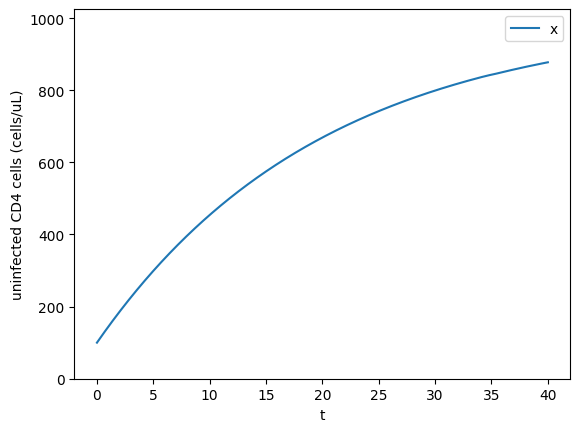

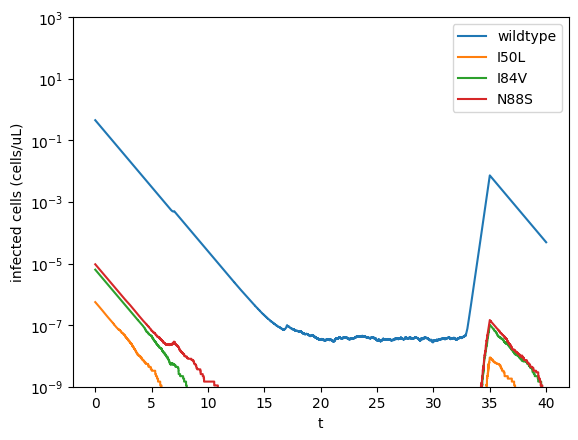

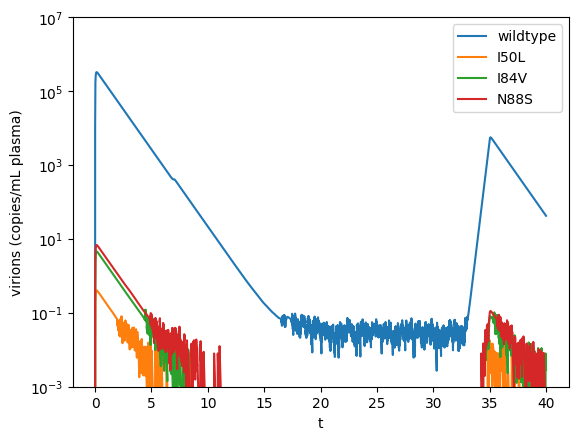

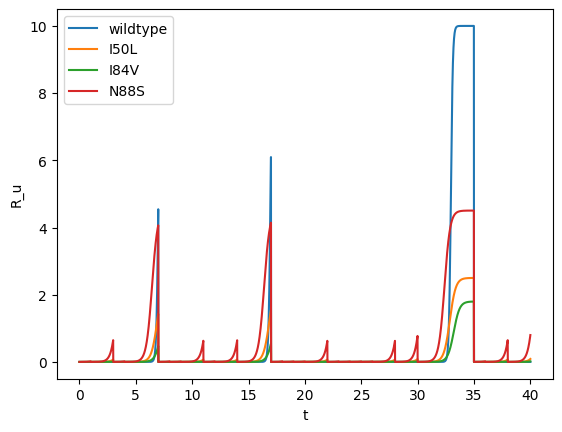

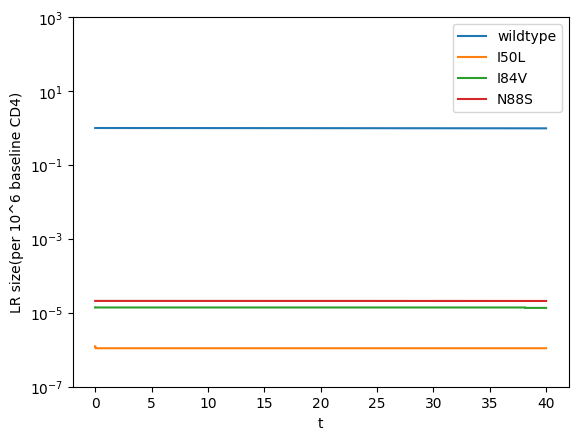

In [65]:
mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T/scale_cd4_body, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('infected cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-9, 1e3])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(vs[0]):model.species.index(vs[-1])+1].T/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])

In [33]:
result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1][:,-1]/(10**6)/(L/dx)

array([9.80032875e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [34]:
print(model.pretty(skip_blanks=True))

                      :  0  --> 1target cells
                      :1target cells -->   0 
                      :  1infected cells strain 0 -->   0 
                      :  1infected cells strain 1 -->   0 
                      :  1infected cells strain 2 -->   0 
                      :  1infected cells strain 3 -->   0 
                      :  1infected cells strain 0 -->   >9viruses strain 0
                      :  1infected cells strain 1 -->   >9viruses strain 1
                      :  1infected cells strain 2 -->   >9viruses strain 2
                      :  1infected cells strain 3 -->   >9viruses strain 3
                      :  1infected cells strain 0 -->   1latent cells strain 0
                      :  1infected cells strain 1 -->   1latent cells strain 1
                      :  1infected cells strain 2 -->   1latent cells strain 2
                      :  1infected cells strain 3 -->   1latent cells strain 3
                      :  1latent cells strain 0 -->   1i

In [35]:
model.k(0)[-11] * L/dx * N

AttributeError: 'Model' object has no attribute 'k'

In [ ]:
def dydt_factory(calculate_propensities):
    def dydt(t, y_expanded, k, deterministic_mask, stochastic_mask, hitting_point):
        y = y_expanded[:-1]
        k = k(t)
        propensities = calculate_propensities(y, k)
        deterministic_propensities = propensities * deterministic_mask
    
        deterministic_propensities
        dydt = np.zeros(len(y_expanded))
    
        ## reaction rates used multiple times 
        _infections = deterministic_propensities[r.index(viral_clearance[-1])+1:len(r)].reshape(n, n)
        new_infections_by_strain = _infections.sum(axis=0)
        loss_of_virions_by_strain = _infections.sum(axis=1)
    
        ic_death = deterministic_propensities[r.index(infected_death[0]):r.index(infected_death[0])+n]
        ic_burst = deterministic_propensities[r.index(infected_cell_burst[0]):r.index(infected_cell_burst[0])+n]
        to_latent = deterministic_propensities[r.index(into_latency[0]):r.index(into_latency[0])+n]
        from_latent = deterministic_propensities[r.index(out_of_latency[0]):r.index(out_of_latency[0])+n]
    
        ## Infected cells
        dydt[1:1+n] = (
            fa * new_infections_by_strain
            + from_latent
            - ic_death
            - ic_burst
            - to_latent
        )
    
        ## Virions
        dydt[1+n:1+2*n] = (
            burst_size * ic_burst
            - loss_of_virions_by_strain
            - deterministic_propensities[r.index(viral_clearance[0]):r.index(viral_clearance[0])+n]
        )
    
        ## Latent cells
        dydt[species.index(zs[0]):species.index(zs[0])+n] = (
            to_latent
            - from_latent
            - deterministic_propensities[r.index(death_of_latent[0]):r.index(death_of_latent[0])+n]
        )
    
        ## Target cells
        dydt[species.index(x)] = deterministic_propensities[r.index(target_cell_birth)] - deterministic_propensities[r.index(target_cell_death)] - np.sum(loss_of_virions_by_strain)
        dydt[-1] = np.sum(propensities * stochastic_mask)
        return dydt
    return dydt

In [ ]:
#rates = N @ deterministic_propensities

#fa = 0.01
species = tuple(model.species.copy())
r = tuple(model.all_reactions.copy())
n = len(ys)
burst_size = N

num_pathways = len(r)
clearance_start = r.index(viral_clearance[0])
clearance_end = r.index(viral_clearance[-1])
ic_death_start = r.index(infected_death[0])
ic_burst_start = r.index(infected_cell_burst[0])
to_latent_start = r.index(into_latency[0])
from_latent_start = r.index(out_of_latency[0])
latent_death_start = r.index(death_of_latent[0])
target_birth = r.index(target_cell_birth)
target_death = r.index(target_cell_death)

latent_start = species.index(zs[0])
ic_start = species.index(ys[0])
virus_start = species.index(vs[0])
x_start = species.index(x)

def jit_dydt_factory(_, calculate_propensities):
    @jit(nopython=True)
    def dydt(t, y_expanded, k, deterministic_mask, stochastic_mask, hitting_point):
        y = y_expanded[:-1]
        propensities = calculate_propensities(y, k, t)
        deterministic_propensities = propensities * deterministic_mask
    
        deterministic_propensities
        dydt = np.zeros(len(y_expanded))
    
        ## reaction rates used multiple times 
        _infections = deterministic_propensities[clearance_end+1:clearance_end+1+n**2].reshape(n, n)
        new_infections_by_strain = _infections.sum(axis=0)
        loss_of_virions_by_strain = _infections.sum(axis=1)
    
        ic_death = deterministic_propensities[ic_death_start:ic_death_start+n]
        ic_burst = deterministic_propensities[ic_burst_start:ic_burst_start+n]
        to_latent = deterministic_propensities[to_latent_start:to_latent_start+n]
        from_latent = deterministic_propensities[from_latent_start:from_latent_start+n]
    
        ## Infected cells
        dydt[ic_start:ic_start+n] = (
            fa * new_infections_by_strain
            + from_latent
            - ic_death
            - ic_burst
            - to_latent
        )
    
        ## Virions
        dydt[virus_start:virus_start+n] = (
            burst_size * ic_burst
            - loss_of_virions_by_strain
            - deterministic_propensities[clearance_start:clearance_start+n]
        )
    
        ## Latent cells
        dydt[latent_start:latent_start+n] = (
            to_latent
            - from_latent
            - deterministic_propensities[latent_death_start:latent_death_start+n]
        )
    
        ## Target cells
        dydt[x_start] = (
            deterministic_propensities[target_birth]
            - deterministic_propensities[target_death]
            - np.sum(loss_of_virions_by_strain)
        )
        
        dydt[-1] = np.sum(propensities * stochastic_mask)
        return dydt
    return dydt

In [ ]:
%%flame
rng = np.random.default_rng(0)

result = hybrid.forward_time(
    y0,
    [0, 40.0],
    model.get_k(jit=True),
    model.stoichiometry(),
    model.rate_involvement(),
    rng,
    partition_function = hybrid.FixedThresholdPartitioner(200).partition_function,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True,
    expert_dydt_factory = jit_dydt_factory
)

Jumping from 0.9999999999999999 to 1.0000000000000002 to avoid discontinuity
Jumping from 2.9999999999999996 to 3.0000000000000004 to avoid discontinuity
Jumping from 3.9999999999999996 to 4.000000000000001 to avoid discontinuity
Jumping from 6.999999999999999 to 7.000000000000001 to avoid discontinuity
Jumping from 7.999999999999999 to 8.000000000000002 to avoid discontinuity
Jumping from 8.999999999999998 to 9.000000000000002 to avoid discontinuity
Jumping from 10.999999999999998 to 11.000000000000002 to avoid discontinuity
Jumping from 11.999999999999998 to 12.000000000000002 to avoid discontinuity
Jumping from 13.999999999999998 to 14.000000000000002 to avoid discontinuity
Jumping from 16.999999999999996 to 17.000000000000004 to avoid discontinuity
Jumping from 17.999999999999996 to 18.000000000000004 to avoid discontinuity
Jumping from 18.999999999999996 to 19.000000000000004 to avoid discontinuity
Jumping from 19.999999999999996 to 20.000000000000004 to avoid discontinuity
Jumpin

         15625758 function calls (15307876 primitive calls) in 8.392 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14245    0.802    0.000    0.911    0.000 ffi.py:188(__call__)
   189076    0.727    0.000    0.766    0.000 2262796886.py:26(dydt)
    29036    0.562    0.000    3.075    0.000 rk.py:14(rk_step)
   189076    0.462    0.000    4.362    0.000 ivp.py:539(fun)
   407875    0.290    0.000    0.572    0.000 functions.py:524(__init__)
    28623    0.268    0.000    0.319    0.000 ivp.py:130(find_active_events)
408811/408785    0.211    0.000    1.358    0.000 abstract.py:61(__call__)
    56677    0.208    0.000    0.562    0.000 rk.py:558(_call_impl)
    28623    0.203    0.000    3.456    0.000 rk.py:111(_step_impl)
     7430    0.188    0.000    7.728    0.001 hybrid.py:202(hybrid_step)
   407881    0.171    0.000    0.171    0.000 dispatcher.py:721(__repr__)
    56677    0.147    0.000    0.245    0.000 shap

In [ ]:
%%time
rng = np.random.default_rng(0)
result = hybrid.forward_time(
    y0,
    [0, 70.0],
    model.get_k(jit=True),
    model.stoichiometry(),
    model.rate_involvement(),
    rng,
    partition_function = hybrid.FixedThresholdPartitioner(100).partition_function,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True,
    expert_dydt_factory = jit_dydt_factory
)

Jumping from 0.9999999999999999 to 1.0000000000000002 to avoid discontinuity
Jumping from 2.9999999999999996 to 3.0000000000000004 to avoid discontinuity
Jumping from 3.9999999999999996 to 4.000000000000001 to avoid discontinuity
Jumping from 6.999999999999999 to 7.000000000000001 to avoid discontinuity
Jumping from 7.999999999999999 to 8.000000000000002 to avoid discontinuity
Jumping from 8.999999999999998 to 9.000000000000002 to avoid discontinuity
Jumping from 10.999999999999998 to 11.000000000000002 to avoid discontinuity
Jumping from 11.999999999999998 to 12.000000000000002 to avoid discontinuity
Jumping from 13.999999999999998 to 14.000000000000002 to avoid discontinuity
Jumping from 16.999999999999996 to 17.000000000000004 to avoid discontinuity
Jumping from 17.999999999999996 to 18.000000000000004 to avoid discontinuity
Jumping from 18.999999999999996 to 19.000000000000004 to avoid discontinuity
Jumping from 19.999999999999996 to 20.000000000000004 to avoid discontinuity
Jumpin

AssertionError: integration step failed

In [ ]:
result

SimulationResult(t=40.0, y=array([2.39314701e+12, 1.44122000e+05, 0.00000000e+00, 0.00000000e+00,
       8.00000000e+00, 1.36401930e+09, 0.00000000e+00, 0.00000000e+00,
       9.87400000e+03, 2.67280700e+06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00]), n_stochastic=7406, nfev=189076, t_history=array([0.00000000e+00, 6.24193126e-18, 6.86612439e-17, ...,
       3.99973159e+01, 3.99986346e+01, 4.00000000e+01]), y_history=array([[2.72727273e+11, 2.72727273e+11, 2.72727273e+11, ...,
        2.39310217e+12, 2.39312420e+12, 2.39314701e+12],
       [1.22727273e+09, 1.22727273e+09, 1.22727273e+09, ...,
        1.44510038e+05, 1.44319614e+05, 1.44122722e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+0

In [ ]:
mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T/scale_cd4_body, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('infected cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-9, 1e3])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(vs[0]):model.species.index(vs[-1])+1].T/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])